### Exploration des Chemins du Bonheur : Atelier d'Analyse avec Arbres de Décision

Les scores de bonheur des pays sont influencés par diverses caractéristiques socio-économiques et géographiques. Dans notre dataset, nous disposons de variables telles que la région, le PIB par habitant, la liberté, la santé, et d'autres facteurs qui peuvent influencer le niveau de bonheur. Pour mieux comprendre l'impact de ces différentes caractéristiques et prédire les scores de bonheur, nous allons utiliser un arbre de décision.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


/tmp/ipykernel_17122/3246982700.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Charger les données en spécifiant le bon séparateur (virgule)
data = pd.read_csv('2015.csv', sep=',')


In [20]:
data.columns = data.columns.str.strip()

In [21]:
print(data.head())

       Country          Region  Happiness Rank  Happiness Score  \
0  Switzerland  Western Europe               1            7.587   
1      Iceland  Western Europe               2            7.561   
2      Denmark  Western Europe               3            7.527   
3       Norway  Western Europe               4            7.522   
4       Canada   North America               5            7.427   

   Standard Error  Economy (GDP per Capita)   Family  \
0         0.03411                   1.39651  1.34951   
1         0.04884                   1.30232  1.40223   
2         0.03328                   1.32548  1.36058   
3         0.03880                   1.45900  1.33095   
4         0.03553                   1.32629  1.32261   

   Health (Life Expectancy)  Freedom  Trust (Government Corruption)  \
0                   0.94143  0.66557                        0.41978   
1                   0.94784  0.62877                        0.14145   
2                   0.87464  0.64938           

Chargement et préparation des données

In [4]:
# Sélectionner les caractéristiques (features) et la variable cible (target)
features = data[['Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)', 'Generosity']]
target = data['Happiness Score']

# Encodage des variables catégoriques
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
X_encoded = pd.DataFrame(encoder.fit_transform(features[categorical_cols]))
X_encoded.columns = encoder.get_feature_names_out(input_features=categorical_cols)

features.drop(columns=categorical_cols, inplace=True)
X = pd.concat([features, X_encoded], axis=1)

/tmp/ipykernel_17122/2440133516.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.drop(columns=categorical_cols, inplace=True)


In [5]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)


Recherche des meilleurs hyperparamètres pour l'arbre de décision

In [6]:
# Définition de l'arbre de décision
tree = DecisionTreeRegressor()

# Définition de la grille des hyperparamètres à rechercher
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Recherche des meilleurs hyperparamètres avec validation croisée
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Affichage des meilleurs hyperparamètres et de la performance associée
print("Meilleurs hyperparamètres trouvés :")
print(grid_search.best_params_)
print("Meilleure performance : {:.2f}".format(-grid_search.best_score_))


Meilleurs hyperparamètres trouvés :
{'criterion': 'friedman_mse', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Meilleure performance : 0.43


Entraînement du modèle avec les meilleurs hyperparamètres

In [7]:
# Entraînement du modèle avec les meilleurs hyperparamètres
best_tree = grid_search.best_estimator_
best_tree.fit(X_train, y_train)

# Prédire les scores de bonheur sur l'ensemble de test
y_pred = best_tree.predict(X_test)

# Calculer l'erreur quadratique moyenne et le coefficient de détermination R^2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Erreur quadratique moyenne (MSE) : {:.2f}".format(mse))
print("Coefficient de détermination (R^2) : {:.2f}".format(r2))


Erreur quadratique moyenne (MSE) : 0.42
Coefficient de détermination (R^2) : 0.70


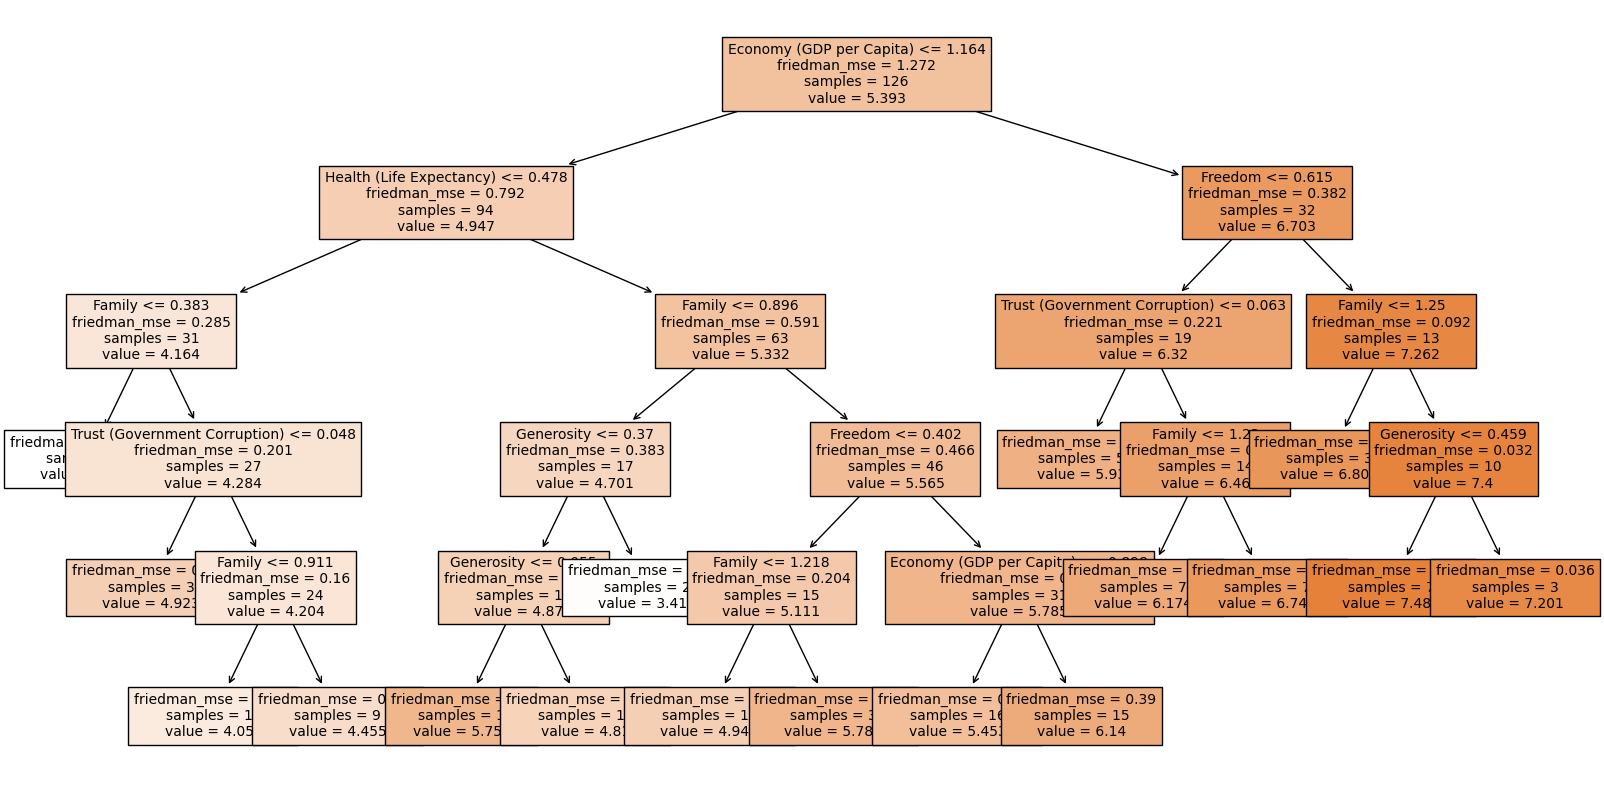

In [8]:
# Visualisation de l'arbre de décision
plt.figure(figsize=(20, 10))
plot_tree(best_tree, feature_names=X.columns, filled=True, fontsize=10)
plt.show()
